**Usual imports**

In [1]:
from __future__ import division, print_function
%matplotlib inline

import itertools
import sklearn

import numpy as np
import pandas as pd
import sklearn.cross_validation as cv
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
# verbose level to handle prints
verbose = 1

# Load the Data

Remind here what it is.

In [3]:
from sklearn.preprocessing import LabelEncoder
filename = "Data/train.csv"
data = pd.read_csv(filename, index_col=0)
X = np.array(data.ix[:,0:-1])
y = np.array(data.ix[:,-1])
classes = np.unique(y)
y = LabelEncoder().fit_transform(y)

if verbose : 
    print("Classes :",", ".join(classes))
    print("Classes codes :",", ".join([str(c) for c in np.unique(y)]))


Classes : Class_1, Class_2, Class_3, Class_4, Class_5, Class_6, Class_7, Class_8, Class_9
Classes codes : 0, 1, 2, 3, 4, 5, 6, 7, 8


## Preprocessing

Remind here what and why.

In [4]:
#X = np.log(1+X)

## Spliting the data

Cross-validation, Validation set, etc.

In [5]:
# 10 folds-cross validation :
kfold = cv.StratifiedKFold(y,
                           n_folds=10,
                           shuffle=True,
                           random_state=0)
# iterator : return train_idx, test_idx with 9 folds in train and 1 in test

# Models

What model are used and why.


In [6]:
# TREES 
from sklearn.tree import DecisionTreeClassifier

trees = [DecisionTreeClassifier(max_depth=10),
         DecisionTreeClassifier(max_depth=100),
         DecisionTreeClassifier(max_depth=1000)]
trees_names = [
    "Tree-10",
    "Tree-100",
    "Tree-1000",
]

In [7]:
# SVMs
from sklearn.svm import SVC

svm = [SVC(),
      ]
svm_names = [
    "SVM",
    ]

In [8]:
# RANDOM FORESTS
from sklearn.ensemble import RandomForestClassifier

rf = [RandomForestClassifier(n_estimators=10),
      RandomForestClassifier(n_estimators=50),
      RandomForestClassifier(n_estimators=100),
     ]
rf_names = [
    "RF-10",
    "RF-50",
    "RF-100",
    ]

In [9]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB

bayes = [GaussianNB(),
         BernoulliNB()
        ]
bayes_names = [
    "GausianNB",
    "BernoulliNB",
]

## Les notres


In [10]:
from gauss_nb import GBayes
from kmean import Kmeans
from multi_perceptron import mPerceptron
from sklearn.pipeline import Pipeline


ours = [GBayes(),
        Pipeline( [("Kmeans", Kmeans(10)), 
                   ("mPerceptron", mPerceptron(0.25, 50))] ),
        Pipeline( [("Kmeans", Kmeans(20)), 
                   ("mPerceptron", mPerceptron(0.25, 50))] ),
        mPerceptron(0.25, 30),
        mPerceptron(0.25, 50),
        mPerceptron(0.15, 30),
        mPerceptron(0.3, 100),
       ]
ours_names = [
    "GBayes",
    "10-means-MPerceptron-0.25-50",
    "20-means-MPerceptron-0.25-50",
    "MPerceptron-0.25-30",
    "MPerceptron-0.25-50",
    "MPerceptron-0.15-30",
    "MPerceptron-0.3-100",
]

# Evaluation

Here we are going to evaluate the models

## Evaluation functions & Metrics

List the evaluation functions & the metrics.


###  Metrics

In [11]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

### Graphics

TODO : 

http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.learning_curve.html


In [12]:
def model_rank(names, results, key):
    loss = np.array([res[key] for res in results])
    std_loss = np.array([res['std_'+key] for res in results])
    order = np.argsort(loss)
    x = range(len(models))
    fig, ax = plt.subplots()
    sort_idx = np.argsort(loss)
    loss = loss[sort_idx]
    std_loss = std_loss[sort_idx]
    ax.plot(x, loss, 'o--')
    ax.fill_between(x, loss - std_loss,
                     loss + std_loss, alpha=0.1,
                     color="r")
    names = [names[i] for i in order]
    plt.xticks(x, names, rotation='vertical')
    ax.set_title("Model ranking")
    ax.set_xlabel("Model")
    ax.set_ylabel(key)
    return fig, ax
    

## Results

Here are gathered graphics, tables, etc.


In [13]:
# Define the model list:
models = ours + trees + bayes 
model_names = ours_names + trees_names + bayes_names 

In [14]:
# For each model :
results = []
plots = []
for model, name in zip(models, model_names):
    if verbose : 
        print("Runing {0}".format(name))
    # Initialise the dict
    metrics = dict()
    metrics['log_loss'] = []
    metrics['accuracy'] = []
    metrics['error'] = []
    metrics['confusion'] = []
    for train_index, test_index in kfold:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # train the model :
        model.fit(X_train, y_train)
        pred_test = model.predict(X_test)
        pred_train = model.predict(X_train)
        pred_proba = None
        if hasattr(model, 'predict_proba'):
            pred_proba = model.predict_proba(X_test)
        # Evaluate :
        if pred_proba is None:
            metrics['log_loss'].append(log_loss(y_test, pred_test))
        else:
            metrics['log_loss'].append(log_loss(y_test, pred_proba))
        acc = accuracy_score(y_test, pred_test)
        metrics['accuracy'].append(acc)
        metrics['error'].append(1-acc)
        metrics['confusion'].append(confusion_matrix(y_test, pred_test))
    # Compute variance metrics :
    metrics['std_log_loss'] = np.std(metrics['log_loss'])
    metrics['std_accuracy'] = np.std(metrics['accuracy'])
    metrics['std_error'] = np.std(metrics['error'])
    metrics['std_confusion'] = np.std(np.array(metrics['confusion']), axis=0)
    # Mean all metrics :
    metrics['log_loss'] = np.mean(metrics['log_loss'])
    metrics['accuracy'] = np.mean(metrics['accuracy'])
    metrics['error'] = np.mean(metrics['error'])
    metrics['confusion'] = np.mean(np.array(metrics['confusion']), axis=0)
    
    results.append(metrics)

Runing GBayes
(6192, 9)
(6191, 9)
(6190, 9)
(6190, 9)
(6188, 9)
(6186, 9)
(6186, 9)
(6186, 9)
(6186, 9)
(6183, 9)
Runing 10-means-MPerceptron-0.25-50
Runing 20-means-MPerceptron-0.25-50
Runing MPerceptron-0.25-30
Runing MPerceptron-0.25-50
Runing MPerceptron-0.15-30
Runing MPerceptron-0.3-100
Runing Tree-10
Runing Tree-100
Runing Tree-1000
Runing GausianNB
Runing BernoulliNB


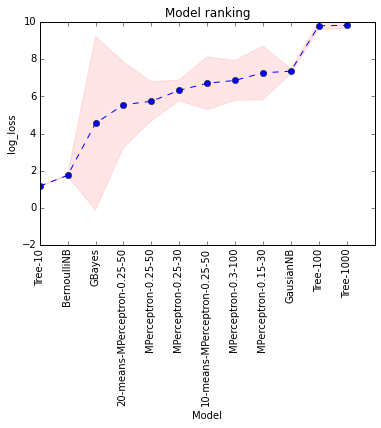

In [15]:
fig, ax = model_rank(model_names, results, "log_loss")
plt.show()

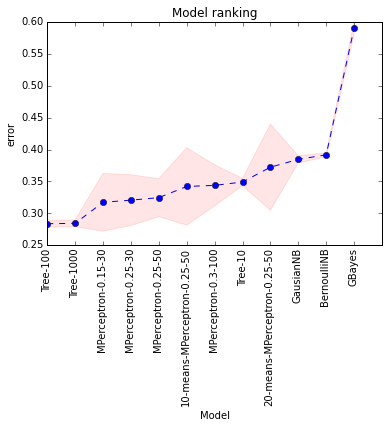

In [16]:
fig, ax = model_rank(model_names, results, "error")
plt.show()